In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score

from tqdm import tqdm

import warnings; warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
import random
import os

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
from pathlib import Path
DATA_PATH = Path("C:/ML_Projects/kaggle-workflow/data/")
OUTPUT_PATH = Path("C:/ML_Projects/kaggle-workflow/output/")

# General settings
SEED = 42
N_FOLDS = 5

# Metric choice placeholder
#Adjust depending on the competition
METRIC = "auc"

In [4]:
PATH = Path.cwd()

In [5]:
#Load OOF
oof = pd.read_csv(PATH / "oof_predictions.csv")
oof.head()

,id,target,oof_pred_MLP,oof_pred_LGBM,oof_pred_Cat,oof_pred_svc
0,0,1.0,0.608593,0.498156,0.470012,0.561891
1,1,1.0,0.644023,0.592414,0.583317,0.594351
2,2,0.0,0.292208,0.248972,0.249189,0.272362
3,3,1.0,0.666945,0.533050,0.532701,0.629540
4,4,1.0,0.748159,0.776689,0.763086,0.702487


In [6]:
X_train=oof.drop(columns = ["target", "id", "oof_pred_svc", "oof_pred_LGBM"])
y_train = oof["target"]
X_train.head()

,oof_pred_MLP,oof_pred_Cat
0,0.608593,0.470012
1,0.644023,0.583317
2,0.292208,0.249189
3,0.666945,0.532701
4,0.748159,0.763086


Text(0.5, 1.0, 'Triangle correlation heatmap')

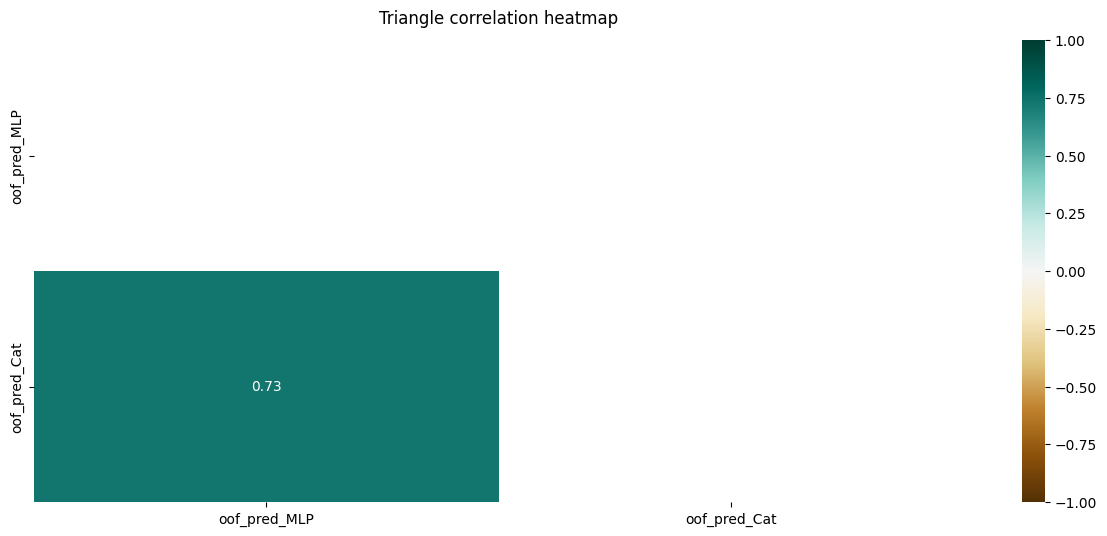

In [7]:
cor_matrix = X_train.corr()
mask = np.triu(np.ones_like(cor_matrix, dtype = "bool"))
plt.figure(figsize = (15,6))
heatmap = sns.heatmap(cor_matrix, mask = mask, annot=True, vmin = -1, vmax = 1, cmap='BrBG')
heatmap.set_title('Triangle correlation heatmap', fontdict={'fontsize':12}, pad=12)

In [8]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [10]:
test = pd.read_csv(PATH / "test_pred_models.csv")
test = test.rename(columns = ({"prediction_MLP" : "oof_pred_MLP", "prediction_LGBM" : "oof_pred_LGBM", "prediction_Cat" : "oof_pred_Cat"}))
X_test = test.drop(columns = ["id", "oof_pred_LGBM", "prediction_SVC"])
X_test.head()

,oof_pred_MLP,oof_pred_Cat
0,0.602803,0.508414
1,0.642024,0.672573
2,0.685453,0.786095
3,0.633595,0.423093
4,0.867566,0.921526


In [11]:
probs = meta_model.predict_proba(X_test)[:, 1]
probs

array([0.49176193, 0.70194466, 0.81098338, ..., 0.54644268, 0.63236334,
       0.61817003], shape=(300000,))

In [12]:
sub = pd.read_csv(DATA_PATH / "Diabetes Prediction Challenge" / "sample_submission.csv")

In [13]:
sub["diagnosed_diabetes"] = probs
sub.head()

,id,diagnosed_diabetes
0,700000,0.491762
1,700001,0.701945
2,700002,0.810983
3,700003,0.367412
4,700004,0.885913


In [14]:
sub.to_csv("dia_submission_ens_3.csv", index=False)